## Introduction

The objective of the project is to train the machine and predict a digit from ten of the digits, using convolutional neural network **(CNN)** with using **tensorflow** API. The original dataset is taken from **Kaggle** website under the name "Digit Recognizer".

### Problem Description and attribure information:

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import tensorflow as tf
import time
from sklearn.utils import shuffle

In [2]:
from tensorflow.python.framework import ops

Loading the dataset

In [3]:
train_df = pd.read_csv('C:/Users/g.singh.choudhary/Desktop/Python/Kaggle Workplace/Digit Recognizer/train.csv')
test_df = pd.read_csv('C:/Users/g.singh.choudhary/Desktop/Python/Kaggle Workplace/Digit Recognizer/test.csv')

In [4]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df.shape, test_df.shape

((42000, 785), (28000, 784))

So the model can be trained on 42k images of 28x28 (=784) pixel and then we'll predict the 28k images of test set to evalueate the model accuracy on unseen data. The first feature of training set is label of the sample and rest are all flattened pixels of image.

Lets display few images of training dataset to get insights of data

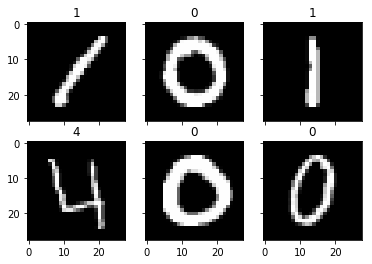

In [6]:
fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(6):
    ax[i].imshow(train_df.iloc[i, 1:].values.reshape(28, 28), cmap = 'gray', interpolation = 'nearest')
    ax[i].set_title(train_df.iloc[i, 0])
plt.show()

By seeing the above six images we can't assume that images are in random order. Lets randomly shuffle the data to make our model general and avoid pattern.

In [7]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)

In [8]:
X = train_df.iloc[:, 1:].values/255.
Y = train_df.iloc[:, 0].values
X_test = test_df.values/255.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [10]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [11]:
X_train.shape, Y_train.shape

((33600, 28, 28, 1), (33600,))

In [12]:
X_val.shape, Y_val.shape

((8400, 28, 28, 1), (8400,))

In [13]:
X_test.shape

(28000, 28, 28, 1)

In [14]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Y_train  = lb.fit_transform(Y_train)
Y_val = lb.transform(Y_val)

In [15]:
Y_train.shape, Y_val.shape

((33600, 10), (8400, 10))

Now the dataset is ready to be feeded to algorithms.

### Tensorflow Model:

We'll implement a fully functional convolation model using tesorflow, with convoluational, pooling and fully connected layers. For creating the complete model, we are implementing some helper functions which will be used in Model.

##### Method 1: Create Placeholders

Implementing the method to create the placeholders for input image X and output Y. We'll not define the number of training examples for the moment. We are choosing 'None' as the batch size, which will give us the flexibility to choose it later.

In [16]:
def create_placeholders(height, width, n_classes):
    
    X = tf.placeholder(tf.float32, [None, height, width, 1])
    Y = tf.placeholder(tf.float32, [None, n_classes])
    
    return X, Y

For our dataset it'll create placeholders of shape [batch_size, 64, 64] for input and [batch_size, 10] for output.

##### Method 2: Initialize Parameters

We are initializing weights / filters for conv2d functions in convolution layers. Tensorflow initializes weights for fully connected layers automatically.

In [17]:
def initialize_parameters(name, shape):
    
    weight = tf.get_variable(name, shape, initializer = tf.contrib.layers.xavier_initializer(seed =1))
    
    return weight

##### Method 3: Forward Propagation

In tensorflow, there are built-in functions to carry out convolution steps for us. The follwing are the methods which can help us to build a forward propagation network.<br>
**conv2d** - Convolves filters on input with given stride and padding strategy<br>
**max_pool** - To carry out max pooling over each window with given size and padding<br>
**relu** - Computes the elementwize relu of input<br>
**flatten** - Flattens the input into 1D vector<br>
**fully_connected** - Given a flattened input, it returns output computed using fully connected layer<br>

Here we are implementing the forward propagation for the following model:<br>
**Conv2d->Relu->Maxpool->Conv2d->Relu->Maxpool->Flatten->Fully Connceted**

In [18]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1, 1, 1, 1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1, 8, 8, 1], strides = [1, 8, 8, 1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides = [1, 1, 1,1 ], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding = 'SAME')
    
    F = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(F, 10, activation_fn = None)
    
    return Z3

##### Method 4: Compute Cost

This method will compute the cost using follwoing built-in function in tensforflow.<br>
**softmax_cross_entropy_with_logits** - Computes the softmax entropy loss<br>
**reduce_mean** - Computes the mean of elements across the dimension of a tensor.

In [19]:
def compute_cost(Z3, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    
    return cost

##### Method 5: Random Mini Batches

In [20]:
def random_minibatches(X, Y, minibatch_size, seed = 0):
    m = X.shape[0]
    minibatches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]
    
    n_minibatches = int(m / minibatch_size)
    
    for k in range(n_minibatches):
        minibatch_X = shuffled_X[k * minibatch_size:(k + 1) * minibatch_size, :]
        minibatch_Y = shuffled_Y[k * minibatch_size:(k + 1) * minibatch_size, :]
        minibatch = minibatch_X, minibatch_Y
        minibatches.append(minibatch)
    
    if(m%minibatch_size != 0):
        end = m - minibatch_size * n_minibatches
        minibatch_X = shuffled_X[-end:, :]
        minibatch_Y = shuffled_Y[-end:, :]
        minibatch = minibatch_X, minibatch_Y
        minibatches.append(minibatch)
        
    return minibatches

Finally, we will buid a model and train it on Digits dataset, using the below helper methods:<br>
create_placeholders<br>
initialize_parameter<br>
forward_propagation<br>
compute_cost<br>

### Model

In [32]:
def model(X_train, Y_train, X_test, Y_test, X_predict, learning_rate, num_epochs, minibatch_size):
    
    ops.reset_default_graph()
    seed = 4
    
    m, height, width, _ = X_train.shape
    n_classes = Y_train.shape[1]
    
    costs = []
    
    X, Y =create_placeholders(height, width, n_classes)
    
    W1 = initialize_parameters('W1', [4, 4, 1, 8])
    W2 = initialize_parameters('W2', [2, 2, 8, 16])
    
    parameters ={ 'W1': W1, 'W2': W2}
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size)
            minibatches = random_minibatches(X_train, Y_train, minibatch_size, seed)
            seed += 1
            
            for minibatch in minibatches:
                minibatch_X, minibatch_Y = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                
            if(epoch % 5 == 0):
                print('Cost after epoch %i : %f'%(epoch, minibatch_cost))
            costs.append(minibatch_cost)
            
        #saver = tf.train.Saver()
        #saver.save(sess, './Digits_trained_model')
        
        predict = tf.argmax(Z3, 1)
        actual  = tf.argmax(Y, 1)
        correct_prediction = tf.equal(predict, actual)
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        
        print("\n\nTraining Accuracy : ",train_accuracy)
        print("Test Accuracy : ",test_accuracy)
        
        test_predicted = tf.argmax(Z3, 1)
        Y_predicted = test_predicted.eval({X: X_predict})
        
    
        
    return costs, Y_predicted

In [33]:
costs, Y_test = model(X_train, Y_train, X_val, Y_val, X_test, 0.001, 120, 64)

Cost after epoch 0 : 1.607510
Cost after epoch 5 : 0.260847
Cost after epoch 10 : 0.194286
Cost after epoch 15 : 0.166464
Cost after epoch 20 : 0.150253
Cost after epoch 25 : 0.140095
Cost after epoch 30 : 0.132474
Cost after epoch 35 : 0.126560
Cost after epoch 40 : 0.122475
Cost after epoch 45 : 0.116887
Cost after epoch 50 : 0.113430
Cost after epoch 55 : 0.112438
Cost after epoch 60 : 0.109773
Cost after epoch 65 : 0.106789
Cost after epoch 70 : 0.104343
Cost after epoch 75 : 0.103437
Cost after epoch 80 : 0.102059
Cost after epoch 85 : 0.100625
Cost after epoch 90 : 0.099444
Cost after epoch 95 : 0.098250
Cost after epoch 100 : 0.097286
Cost after epoch 105 : 0.095578
Cost after epoch 110 : 0.094921
Cost after epoch 115 : 0.095201


Training Accuracy :  0.967798
Test Accuracy :  0.960357


**Cost vs No. of epochs**

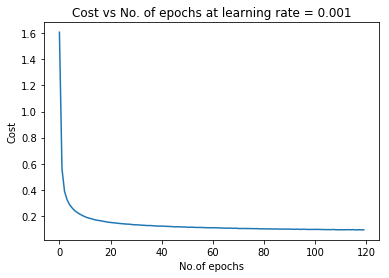

In [34]:
plt.figure()
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('No.of epochs')
plt.title('Cost vs No. of epochs at learning rate = 0.001')
plt.show()

Here we can see that the cost was decreasing rapidly in first few epochs and it's almost saturated in the last few epochs.

#### Export the Test Set

In [39]:
ids = test_df.index.values

In [41]:
labels = Y_test

In [42]:
predicted_set = zip(ids, labels)

In [43]:
predicted_set = sorted(predicted_set )
ids, labels = zip(*(predicted_set))

In [48]:
ids = np.asarray(ids)
labels = np.asarray(labels)

In [50]:
ids = ids+1

In [53]:
output = pd.DataFrame({'ImageId': ids, 'Label' : labels})
output.to_csv('DigitRecognized.csv', index = False)

After submitting this output from our model we got 95.7 % accuracy.

Our model using convolation and pooling layers performed very decent on new data also.<br>
**Model : <br><br>
Conv2d->Relu->Maxpool->Conv2d->Relu->Maxpool->Flatten->Fully Connceted<br><br>
Performance:<br><br>
Training Accuracy : 96.78%<br>
Validation Accuracy : 96.04%<br>
Test Accuracy : 95.7%**<br><br>
Model is quite general and unbiased to unseen data. We can tune model for better accuracy or can make our nework deeper with more layers. But Hardware restriction are making me to be satisfied with this performance only.